# Plotting best SED models from CIGALE

In this Jupyter Notebook we are going to plot different SED from different stage in the proccess to CIGALE build the best SED model for 9 galaxies of our final sample. The galaxies were selected from the best and worst SED fittings.

In [1]:
import numpy as np
import astropy.units as u
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.legend import _get_legend_handles_labels
from astropy.table import Table, Column, table, vstack, setdiff, join
from pathlib import Path

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_fitting = '../Datos/Final/sample_CIGALE_fitting/'
path_no_best_fitting = '../Datos/Final/CIGALE_no_best_fitting/'
path_FINAL = '../Datos/Final/'


out = ['/out_0a90/','/out_30y70/']

In [3]:
Sy_Ne = Table.read(path_FINAL+'Ne_ratios_-_CIGALE_results.tbl', format='ascii')
results = Table.read(path_CIGALE_out+'results0a90_All.fits',format='fits')

## Select best and worst SED fittings

Reading the photometry and count the number of photometry points for the SED fitting for each galaxy and join with the previous Table:

In [4]:
Phot = Table.read(path_FINAL+'CIGPhotSy_EnergyBal_All.tbl', format='ascii')

#Phot['id'] = Phot['id'].astype(object) #Converting the dtype to object
Phot.rename_column('id', 'Main_id')

Phot['CountPoints'] = [sum(~np.isnan(list(j)))/
                       2 for j in Phot[Phot.colnames[2:]].as_array()]

Sy_Ne_SED = join(Phot, Sy_Ne)

In [5]:
print('The galaxy with the less phot points have',min(Sy_Ne_SED['CountPoints']))
print('The galaxy with the more phot points have',max(Sy_Ne_SED['CountPoints']))
print('On the final sample the min log(reduced chi squere) is',min(Sy_Ne_SED['log.reduced_chi_square']))
print('and the max is',max(Sy_Ne_SED['log.reduced_chi_square']))


The galaxy with the less phot points have 11.0
The galaxy with the more phot points have 30.0
On the final sample the min log(reduced chi squere) is -0.4139449343655281
and the max is 0.4784445928035835


For the best galaxy, we select galaxies with more than 20 photometry points and $\chi_{\rm{red}}^{2}$ values close to 1.

In [6]:
All_chis = Sy_Ne_SED['best.reduced_chi_square']

SelecCut = np.logical_and.reduce([All_chis < 1.2,
                                  All_chis > 0.8,
                                  Sy_Ne_SED['CountPoints'] >= 20])

Sy_best_seds = Sy_Ne_SED[SelecCut]
Sy_best_seds

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14
Mrk 493,0.03102,0.9840000129770488,0.09840000129770488,1.5449999773409218,0.15449999773409218,2.130000008037314,0.12369316999999999,4.134999995585531,0.22405355,7.0574997225776315,0.46572523000000005,6.880000117234886,0.6161169,13.000000268220901,0.6164414,11.54199989978224,2.6199808,12.47833338048723,2.8773077999999996,14.087500050663948,2.3622024,20.583333364083913,1.2350000018450347,23.75,0.7125,26.799999999999997,0.8039999999999999,24.518181806938216,1.4710909084162929,37.699999999999996,1.1309999999999998,60.4,1.8119999999999998,nan,nan,67.039999063313,4.0223999437987805,153.8888888789548,9.233333332737287,154.0,6.16,230.33333289623258,34.30146109146118,713.3333311080933,43.33462617969903,nan,nan,nan,nan,1326.666671435038,193.79435518305584,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,22.0,239.79009655029,35.02987815357,Sy1,*|AGN|G|GiG|IR|QSO|Rad|Sy1|UV|X,959000000.0,127000000.0,6270000000.0,131000000.0,0.15295055821371611,0.02050571695239717,959000000.0,127000000.0,2710000000.0,153000000.0,0.35387453874538743,0.050944488640352024,2710000000.0,153000000.0,6270000000.0,131000000.0,0.43221690590111644,0.026019242265538072,0.48784439569267607,0.0594664674645772,20.81643840149958,16.07842496172041,7.501732122761568e+36,3.693705916867564e+36,1.8709113199146746e+37,3.425116227484285e+36,3.224926172995409,0.9545070562582805,11887685924.3393,2952934705.438637,1.1897909068467583,0.0754706454417226,NeII|NeIII|NeV
Mrk 509,0.03407575862939649,5.1499999438722925,0.5149999943872293,5.8400000755985575,0.5840000075598558,nan,nan,13.700000010430813,1.8000000000000003,19.700000062584877,2.6999999999999997,23.900000378489494,2.8,nan,nan,26.950000319629908,3.1144822,39.58124970085919,4.482187000000001,57.76923121168063,4.7265207,96.40499918162823,5.784299950897694,82.64999976158143,4.400007202550923,96.75,2.9025,122.41666721800964,7.345000033080578,132.0,3.96,nan,nan,316.0,28.400000000000002,247.66666921476522,14.860000152885913,608.9166715542476,36.53500029325485,597.5833295186361,23.9033331807

In [7]:
best_seds_id = []
for i,id in enumerate(Sy_best_seds['Main_id']): best_seds_id.append(id)

The best fitting galaxies for Sy1 and Sy2:

In [8]:
BEST_Sy1GAL = 'Mrk  509'
BEST_Sy2GAL = 'NGC  4507'

Reading their data results from CIGALE

In [9]:
best_sed_Sy1 = Table.read(path_fitting+BEST_Sy1GAL+'_best_model.fits', format='fits')
best_sed_Sy1['freq'] = best_sed_Sy1['wavelength'].to(u.Hz,equivalencies=u.spectral())

# This is to define the distance
locat_bg = np.where(results['id'] == BEST_Sy1GAL)
cons_bg = (results['best.universe.luminosity_distance'][locat_bg])**2 * u.m

#---------------------------------------

best_sed_Sy2 = Table.read(path_fitting+BEST_Sy2GAL+'_best_model.fits', format='fits')
best_sed_Sy2['freq'] = best_sed_Sy2['wavelength'].to(u.Hz,equivalencies=u.spectral())

# This is to define the distance
locat_bg_Sy2 = np.where(results['id'] == BEST_Sy2GAL)
cons_bg_Sy2 = (results['best.universe.luminosity_distance'][locat_bg_Sy2])**2 * u.m

For the worst galaxy, we select a galaxy with a $\chi_{\rm{red}}^{2}$ close to our selected limits in the $\chi_{\rm{red}}^{2}$ distribution, with less to 20 photometry points

In [10]:
WorstCut = np.logical_and.reduce([np.logical_xor(All_chis < 10**(0.47),
                                                 All_chis > 10**(-0.41)),
                                 Sy_Ne_SED['CountPoints'] < 20])

no_Sy_best_seds = Sy_Ne_SED[WorstCut]
no_Sy_best_seds

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14
ESO 428-14,0.005554,nan,nan,nan,nan,nan,nan,9.999999776482582,0.2,21.99999988079071,0.49999999999999994,31.89999982714653,2.0,nan,nan,nan,nan,107.40769110046901,24.773374,88.9727273447947,22.819728,nan,nan,36.3,1.089,70.07499820590019,4.400349719340499,70.99999984105428,6.095899999999999,72.1,2.163,188.2500024437904,5.647500073313712,333.4999982789159,30.89902939406402,417.9999977350235,25.495099,1589.9999737739563,95.39999842643738,1450.0000476837158,113.13708,1412.499996125698,84.01785986039457,3407.5000256299973,251.39809017777543,nan,nan,4710.000038146973,551.54324,4555.000047758222,383.1305223356982,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,18.0,109.13002590105002,-29.324689673990008,Sy2,*|AGN|Em*|G|GiG|IR|PN|Sy2,62700000000.0,0.0,50800000000.0,0.0,1.234251968503937,nan,76166666666.66667,0.0,159333333333.33334,0.0,0.4761513525598033,nan,142000000000.0,0.0,50800000000.0,0.0,2.795275590551181,nan,0.6920240404271087,0.04029785388440798,89.76834902070145,1.5078312307712307,8.567175244193584e+32,5.660726754555586e+32,2.512244863623393e+36,1.6986826816723898e+35,0.13350524561725596,0.0823319205253414,3123735481.858563,731046766.5362461,2.953192862460787,0.47029181011015897,NeII|NeIII|NeV
UGC 1395,0.017349037032307058,nan,nan,nan,nan,nan,nan,1.9600000232458115,0.03920000046491623,4.430000204592943,0.08860000409185886,6.099999882280827,0.19,nan,nan,14.474999951198697,2.6153394,20.143000315874815,3.9576255,16.425555468433434,4.011334,10.056904838496731,0.6034142903098039,nan,nan,nan,nan,8.153124969257041,0.48918749815542245,nan,nan,nan,nan,nan,nan,27.049999947100876,1.6229999968260524,77.20833259125551,4.632499955475331,71.90000265836716,2.8760001063346863,nan,nan,483.50000000000006,65.13033087586766,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.0,28.84178271293,6.611787317909999,Sy2,*|AGN|EmO|G|GiG|GrG|IR|Sy2,2000000000.0,1000000000.0,3000000000.0,1000000000.0,0.6666666666666666,0.40061680838488767,2000000000.0,1000000000.0,4000000000.0,1000000000.0,0.

In [11]:
no_best_seds_id = []
for i,id in enumerate(no_Sy_best_seds['Main_id']): no_best_seds_id.append(id)

In [12]:
Phot.remove_column('CountPoints')  # We removing column CounPhot from the Phot

### Creating a sample table between the two tables (best and worst fitting) for the next graphics

The following graphics are just to show the different steps in CIGALE proccess to produce the final SED. All the graphics correspond to the best fitting model for each galaxy. The sample are three Sy1 galaxies and three Sy2 galaxies

In [13]:
sample = vstack([Sy_best_seds[:3],Sy_best_seds[6:],no_Sy_best_seds])
sample.sort('bayes.agn.i')
sample

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14
Mrk 509,0.03407575862939649,5.1499999438722925,0.5149999943872293,5.8400000755985575,0.5840000075598558,nan,nan,13.700000010430813,1.8000000000000003,19.700000062584877,2.6999999999999997,23.900000378489494,2.8,nan,nan,26.950000319629908,3.1144822,39.58124970085919,4.482187000000001,57.76923121168063,4.7265207,96.40499918162823,5.784299950897694,82.64999976158143,4.400007202550923,96.75,2.9025,122.41666721800964,7.345000033080578,132.0,3.96,nan,nan,316.0,28.400000000000002,247.66666921476522,14.860000152885913,608.9166715542476,36.53500029325485,597.5833295186361,23.903333180745445,723.0000088214874,31.970337814918377,1389.999978542328,64.713290752364,1500.0,150.0,1440.0,57.6,1520.0,228.0,nan,nan,689.0,45.199999999999996,1230.0000190734863,123.00000190734863,393.0000066757202,27.51000046730042,156.00000321865082,10.920000225305559,43.99999976158142,6.3639610306789285,27.0,311.04062686800995,-10.723535320979998,Sy1,*|AGN|BH?|G|IR|QSO|Sy1|V*|X|gam,5636666666.666667,1856035829.3955426,12466666666.666666,1384124271.8773484,0.4586232787927704,0.16447990166919113,6060000000.0,1856035829.3955426,15714285714.285715,3361502640.1893544,0.3839262939425475,0.13895899321442523,15733333333.333334,3361502640.1893544,12466666666.666666,1384124271.8773484,1.277375143688703,0.31543141147587395,0.8999967724605764,0.0005195008439903615,10.139067054941032,9.189530241905159,6.840245893558339e+37,3.5526946884039306e+36,1.356348954380336e+38,6.78174477190168e+36,1.0620840229049962,1.0474851920650534,24388526234.841526,14361010392.55176,0.9886786448775274,-0.0049448463556532995,NeII|NeIII|NeV
Mrk 705,0.02878,0.7160000095609576,0.07160000095609576,1.0175000061281025,0.10175000061281025,2.4999999441206455,0.04999999888241291,5.403333343565464,0.6601515,9.003333436946074,0.3312099,9.060000069439411,1.1,nan,nan,14.587500249035656,2.1400935999999997,19.187500060070306,3.4190645,23.228572016315802,2.880972,22.8374999952813,1.3702499997168778,nan,nan,nan,nan,29.266666460285585,1.755999987617135,nan,nan,nan,nan,172.

## Plotting the stellar emision of the best fitting galaxies

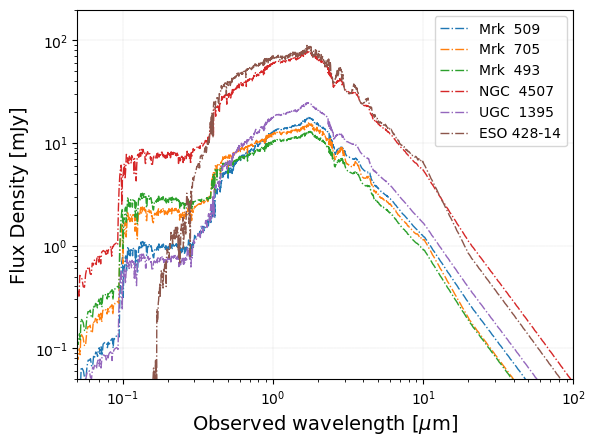

In [14]:
for idx,ids in enumerate(sample['Main_id']):
    #print(ids)
    
    best_seds = Table.read(path_fitting+ids+'_best_model.fits',format='fits')
    best_seds['freq'] = best_seds['wavelength'].to(u.Hz,equivalencies=u.spectral())
    best_seds['stellar'] = best_seds['stellar.old'] + best_seds['stellar.young']
    # This is to define the distance
    locat = np.where(results['id'] == ids)
    cons = (results['best.universe.luminosity_distance'][locat])**2 * u.m
    plt.plot(best_seds['wavelength'].to(u.um),
                    (((best_seds['stellar']*best_seds['wavelength'].to(u.m)).to(u.W))/
                     (cons*4*np.pi)/best_seds['freq']).to(u.mJy),
                    linewidth=1, linestyle='-.',label=ids)

plt.ylabel(r'Flux Density [mJy]', fontsize=14)
plt.xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5e-1, 1e2)
plt.ylim(0.5e-1, 2e2)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

## Plotting the stellar and nebular emision of the best fitting galaxy

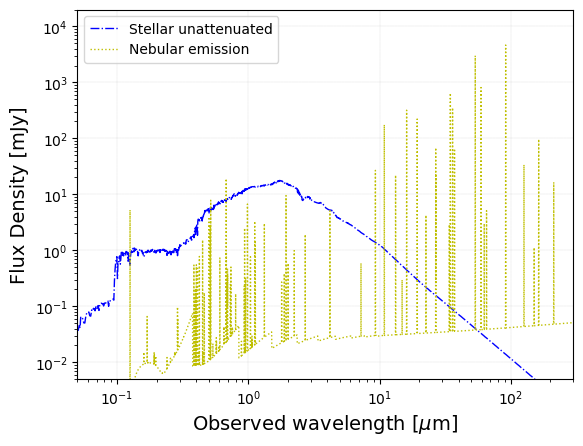

In [15]:
best_sed_Sy1['stellar'] = best_sed_Sy1['stellar.old'] + best_sed_Sy1['stellar.young']
best_sed_Sy1['nebular'] = (best_sed_Sy1['nebular.lines_old']+
                       best_sed_Sy1['nebular.lines_young']+
                       best_sed_Sy1['nebular.continuum_old']+
                       best_sed_Sy1['nebular.continuum_young']+
                       best_sed_Sy1['attenuation.nebular.lines_old']+
                       best_sed_Sy1['attenuation.nebular.lines_young']+
                       best_sed_Sy1['attenuation.nebular.lines_old']+
                       best_sed_Sy1['attenuation.nebular.continuum_young'])

plt.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['stellar']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'b',linewidth=1, linestyle='-.',label='Stellar unattenuated')
plt.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['nebular']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'y', linewidth=1, linestyle=':',label='Nebular emission')


plt.ylabel(r'Flux Density [mJy]', fontsize=14)
plt.xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5e-1,3e2)
plt.ylim(0.5e-2, 2e4)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

## Plotting the attenuation law of the best fitting galaxies

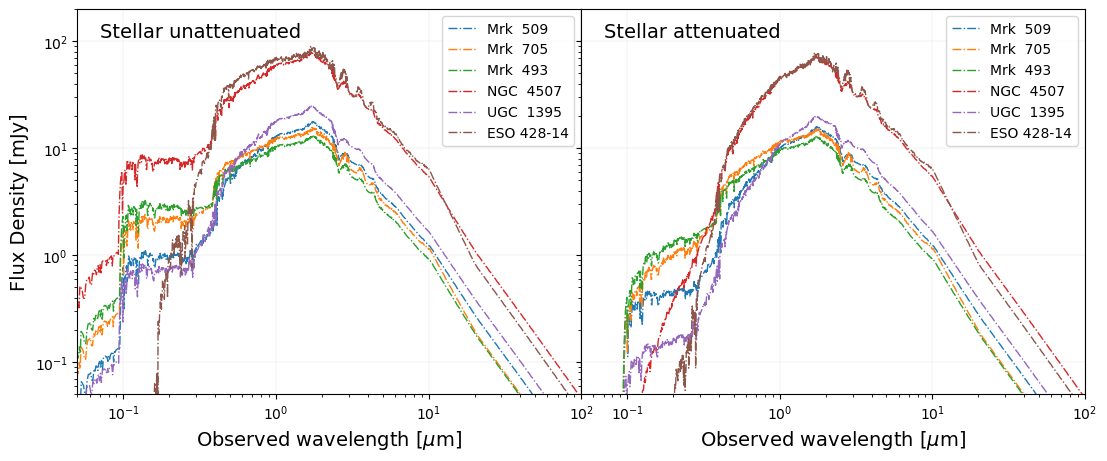

In [16]:
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(13,5),sharey='row')

for idx,ids in enumerate(sample['Main_id']):
    #print(ids)
    
    best_seds = Table.read(path_fitting+ids+'_best_model.fits',format='fits')
    best_seds['freq'] = best_seds['wavelength'].to(u.Hz,equivalencies=u.spectral())
    best_seds['stellar'] = best_seds['stellar.old'] + best_seds['stellar.young']
    best_seds['stellar_atten'] = (best_seds['stellar.old']+best_seds['stellar.young']+
                                  best_seds['attenuation.stellar.old']+
                                  best_seds['attenuation.stellar.young']+
                                  best_seds['nebular.absorption_old']+
                                  best_seds['nebular.absorption_young'])
    
    # This is to define the distance
    locat = np.where(results['id'] == ids)
    cons = (results['best.universe.luminosity_distance'][locat])**2 * u.m
    
    
    ax2.plot(best_seds['wavelength'].to(u.um),
                    (((best_seds['stellar_atten']*best_seds['wavelength'].to(u.m)).to(u.W))/
                     (cons*4*np.pi)/best_seds['freq']).to(u.mJy),
                    linewidth=1, linestyle='-.',label=ids)
    ax1.plot(best_seds['wavelength'].to(u.um),
                    (((best_seds['stellar']*best_seds['wavelength'].to(u.m)).to(u.W))/
                     (cons*4*np.pi)/best_seds['freq']).to(u.mJy),
                    linewidth=1, linestyle='-.',label=ids)

#ax2.set_ylabel(r'Flux Density [mJy]', fontsize=14)
ax2.set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.5e-1, 1e2)
ax2.set_ylim(0.5e-1, 2e2)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.text(0.07,1.1e2,'Stellar attenuated',fontsize=14)
ax2.legend()

ax1.set_ylabel(r'Flux Density [mJy]', fontsize=14)
ax1.set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.5e-1, 1e2)
ax1.set_ylim(0.5e-1, 2e2)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.text(0.07,1.1e2,'Stellar unattenuated',fontsize=14)
ax1.legend()

plt.subplots_adjust(wspace=0.0) #Space between subplots
plt.savefig(path_graphs+'SED_stellar_attenuated.png')

## Plotting the dust emision of the best fitting galaxy

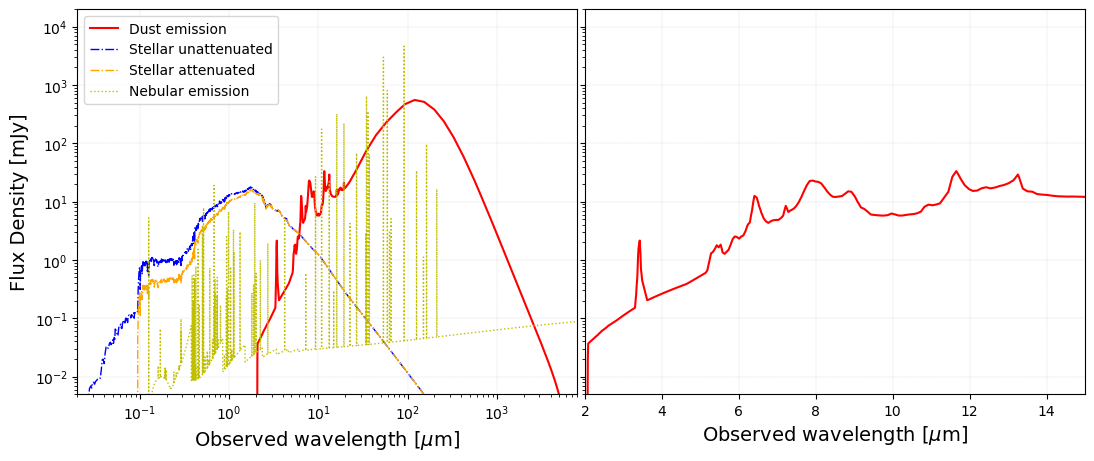

In [17]:
best_sed_Sy1['stellar_atten'] = (best_sed_Sy1['stellar.old']+best_sed_Sy1['stellar.young']+
                                 best_sed_Sy1['attenuation.stellar.old']+
                                 best_sed_Sy1['attenuation.stellar.young']+
                                 best_sed_Sy1['nebular.absorption_old']+
                                 best_sed_Sy1['nebular.absorption_young'])

fig,(ax1, ax2)=plt.subplots(1,2,figsize=(13,5),sharey='row')

ax1.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['dust']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'r', linewidth=1.5,label='Dust emission')
ax1.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['stellar']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'b',linewidth=1, linestyle='-.',label='Stellar unattenuated')
ax1.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['stellar_atten']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'orange',linewidth=1, linestyle='-.',label='Stellar attenuated')
ax1.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['nebular']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'y', linewidth=1, linestyle=':',label='Nebular emission')

ax2.plot(best_sed_Sy1['wavelength'].to(u.um),
         (((best_sed_Sy1['dust']*best_sed_Sy1['wavelength'].to(u.m)).to(u.W))/
          (cons_bg*4*np.pi)/best_sed_Sy1['freq']).to(u.mJy),
         'r', linewidth=1.5,label='Dust emission')

ax1.set_ylabel(r'Flux Density [mJy]', fontsize=14)
ax1.set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(2e-2,0.8e4)
#plt.xlim(0,14)
ax1.set_ylim(0.5e-2, 2e4)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()


ax2.set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
ax2.set_yscale('log')
ax2.set_xlim(2,15)
ax2.set_ylim(0.5e-2, 2e4)
ax2.grid(color='k', linestyle='--', linewidth=0.05)

plt.subplots_adjust(wspace=0.015) #Space between subplots

## Plotting the AGN emision

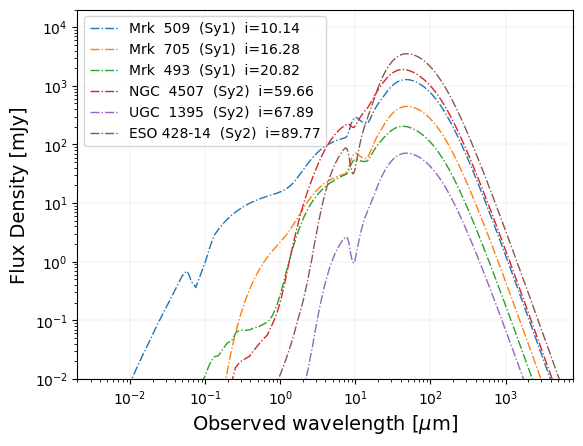

In [18]:
for idx,ids in enumerate(sample['Main_id']):
    #print(ids)
    
    seds = Table.read(path_fitting+ids+'_best_model.fits',format='fits')
    seds['freq'] = seds['wavelength'].to(u.Hz,equivalencies=u.spectral())
    seds['agn'] = (seds['agn.SKIRTOR2016_torus']+
                       seds['agn.SKIRTOR2016_polar_dust']+
                       seds['agn.SKIRTOR2016_disk'])
    # This is to define the distance
    locat = np.where(results['id'] == ids)
    cons = (results['best.universe.luminosity_distance'][locat])**2 * u.m
    plt.plot(seds['wavelength'].to(u.um),
                    (((seds['agn']*seds['wavelength'].to(u.m)).to(u.W))/
                     (cons*4*np.pi)/seds['freq']).to(u.mJy),
                    linewidth=1, linestyle='-.',label=ids+'  ('+
             sample[idx]['otype']+')  i=%.2f' %sample[idx]['bayes.agn.i'])

plt.ylabel(r'Flux Density [mJy]', fontsize=14)
plt.xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-3,0.8e4)
#plt.xlim(0.001,3)
plt.ylim(1e-2, 2e4)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

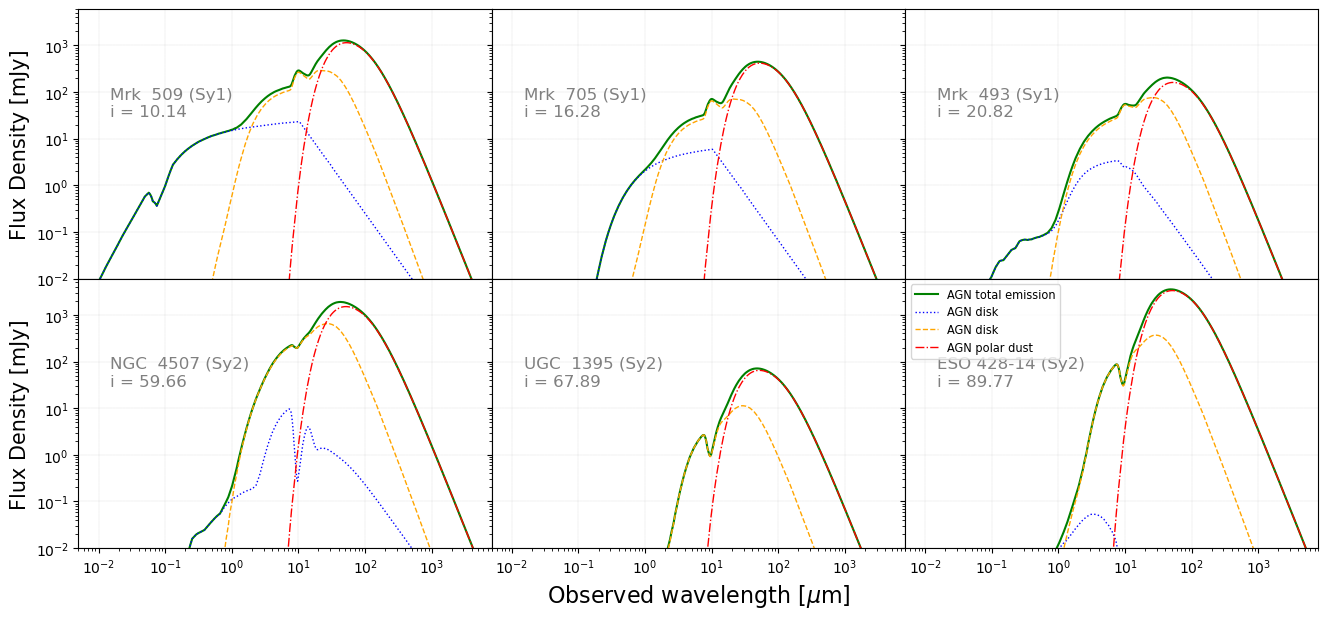

In [19]:
types = ['(Sy1)','(Sy1)','(Sy1)','(Sy2)','(Sy2)','(Sy2)']

fig, axs = plt.subplots(2,3,figsize=(16,7),sharex='col',sharey='row')

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

i=0
j=0

for idx,ids in enumerate(sample['Main_id']):
    sed_Sy = Table.read(path_fitting+ids+'_best_model.fits', format='fits')
    
    # This is to define the distance
    locat_Sy = np.where(results['id'] == ids)
    cons_Sy = (results['best.universe.luminosity_distance'][locat_Sy])**2 * u.m
    
    sed_Sy['freq'] = sed_Sy['wavelength'].to(u.Hz,equivalencies=u.spectral())
    sed_Sy['agn'] = (sed_Sy['agn.SKIRTOR2016_torus']+
                     sed_Sy['agn.SKIRTOR2016_polar_dust']+
                     sed_Sy['agn.SKIRTOR2016_disk'])
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['agn']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'g',
                  linewidth=1.5,label='AGN total emission')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['agn.SKIRTOR2016_disk']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'b',
                  linewidth=1,linestyle='dotted',label='AGN disk')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['agn.SKIRTOR2016_torus']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'orange',
                  linewidth=1,linestyle='dashed',label='AGN disk')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['agn.SKIRTOR2016_polar_dust']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'r',
                  linewidth=1,linestyle='dashdot',label='AGN polar dust')
    axs[i,j].text(0.015,0.3e2,ids+' '+types[idx]+'\ni = %.2f'%sample[idx]['bayes.agn.i'],
                  fontsize=12,color='gray')
    axs[i,j].set_xlim(5e-3,0.8e4)
    axs[i,j].set_ylim(1e-2,6e3)
    axs[i,j].set_xscale('log')
    axs[i,j].set_yscale('log')
    axs[i,j].grid(color='k', linestyle='--', linewidth=0.05)
    axs[i,0].set_ylabel(r'Flux Density [mJy]', fontsize=15)
    j+=1
    if j>2:
        i+=1
        j=0
    
axs[1,1].set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=16)
#fig.supxlabel(r'Observed wavelength [$\mu$m]', fontsize=15)
#fig.supylabel(r'Flux Density [mJy]',fontsize=15)
axs[1,2].legend(fontsize=8.2)
plt.subplots_adjust(hspace=0.0,wspace=0.0) #Space between subplots
plt.show()



## Ploting best model SED from CIGALE for the best  and worst galaxies 

In [20]:
sample_SED = vstack([Sy_best_seds,no_Sy_best_seds])
sample_SED.sort('bayes.agn.i')
sample_SED

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14
Mrk 509,0.03407575862939649,5.1499999438722925,0.5149999943872293,5.8400000755985575,0.5840000075598558,nan,nan,13.700000010430813,1.8000000000000003,19.700000062584877,2.6999999999999997,23.900000378489494,2.8,nan,nan,26.950000319629908,3.1144822,39.58124970085919,4.482187000000001,57.76923121168063,4.7265207,96.40499918162823,5.784299950897694,82.64999976158143,4.400007202550923,96.75,2.9025,122.41666721800964,7.345000033080578,132.0,3.96,nan,nan,316.0,28.400000000000002,247.66666921476522,14.860000152885913,608.9166715542476,36.53500029325485,597.5833295186361,23.903333180745445,723.0000088214874,31.970337814918377,1389.999978542328,64.713290752364,1500.0,150.0,1440.0,57.6,1520.0,228.0,nan,nan,689.0,45.199999999999996,1230.0000190734863,123.00000190734863,393.0000066757202,27.51000046730042,156.00000321865082,10.920000225305559,43.99999976158142,6.3639610306789285,27.0,311.04062686800995,-10.723535320979998,Sy1,*|AGN|BH?|G|IR|QSO|Sy1|V*|X|gam,5636666666.666667,1856035829.3955426,12466666666.666666,1384124271.8773484,0.4586232787927704,0.16447990166919113,6060000000.0,1856035829.3955426,15714285714.285715,3361502640.1893544,0.3839262939425475,0.13895899321442523,15733333333.333334,3361502640.1893544,12466666666.666666,1384124271.8773484,1.277375143688703,0.31543141147587395,0.8999967724605764,0.0005195008439903615,10.139067054941032,9.189530241905159,6.840245893558339e+37,3.5526946884039306e+36,1.356348954380336e+38,6.78174477190168e+36,1.0620840229049962,1.0474851920650534,24388526234.841526,14361010392.55176,0.9886786448775274,-0.0049448463556532995,NeII|NeIII|NeV
Mrk 1383,0.086,nan,nan,nan,nan,5.499999970197678,0.10999999940395355,5.670000100508332,0.22090723,5.940000060945749,0.27073971999999996,10.994999669492245,0.9004998,8.3600003272295,0.16720000654459,10.556428759757962,1.5580758,15.429285421435322,2.017449,23.620833177119493,2.3895816,28.87777763356765,1.7326666580140588,nan,nan,nan,nan,38.08333339889844,2.2850000039339062,nan,nan,nan,nan,nan,nan,89.16428658962249,5.34985

In [21]:
types_SED = ['(Sy1)','(Sy1)','(Sy1)','(Sy1)','(Sy1)','(Sy1)','(Sy2)','(Sy2)','(Sy2)']
sample_sed_id = []
for i,id in enumerate(sample_SED['Main_id']): sample_sed_id.append(id)
print(sample_sed_id)
print(types_SED)

['Mrk  509', 'Mrk 1383', 'Mrk  705', 'Mrk  493', 'NGC  3516', 'Mrk 1298', 'NGC  4507', 'UGC  1395', 'ESO 428-14']
['(Sy1)', '(Sy1)', '(Sy1)', '(Sy1)', '(Sy1)', '(Sy1)', '(Sy2)', '(Sy2)', '(Sy2)']


In [22]:
wavelengths = {"FUV": 0.152, "NUV": 0.227, "u_prime": 0.354, "g_prime": 0.477,
               "r_prime": 0.623, "i_prime": 0.762, "z_prime": 0.913, "J_2mass": 1.25,
               "H_2mass": 1.65, "Ks_2mass": 2.17, "WISE1": 3.4, "IRAC1": 3.6, "IRAC2": 4.5,
               "WISE2": 4.6, "IRAC3": 5.8, "IRAC4": 8.0, "IRAS1": 12.0, "WISE3": 12.0,
               "WISE4": 22.0, "MIPS1": 24.0, "IRAS2": 25.0, "IRAS3": 60.0, "PACS_blue": 70.0,
               "MIPS2": 70.0, "PACS_green": 100.0, "IRAS4": 100.0, "PACS_red": 160.0,
               "MIPS3": 160.0, "PSW_ext": 250.0, "PMW_ext": 350.0, "PLW_ext": 500.0}


filters = [Phot.colnames[x] for x in range(2, len(Phot.colnames), 2)] #Getting the filers names

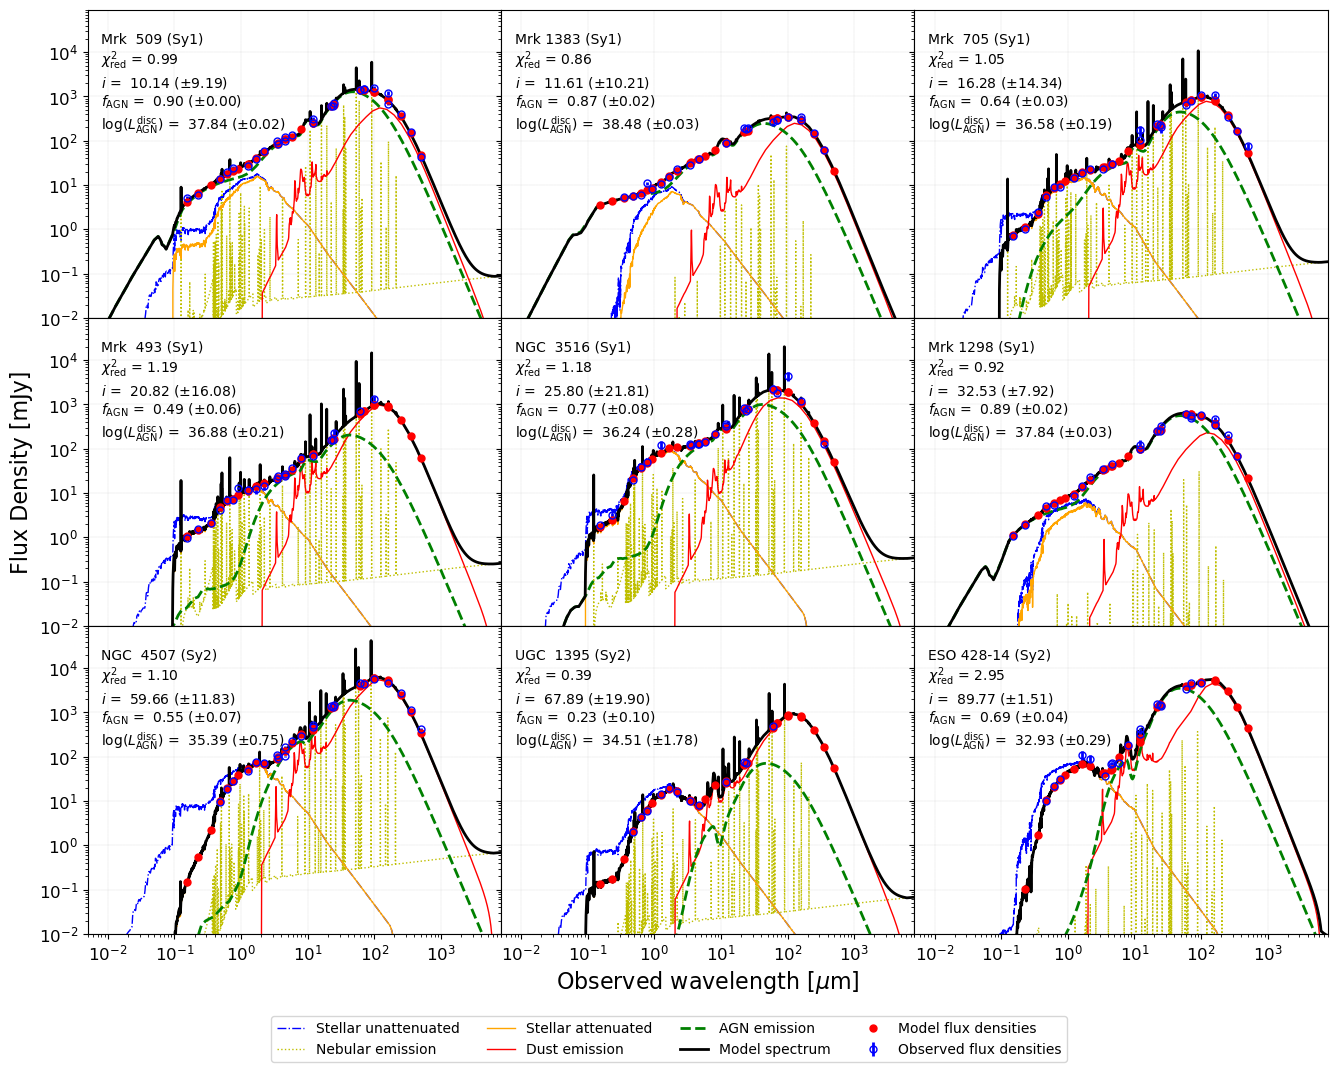

In [23]:
fig, axs = plt.subplots(3,3,figsize=(16,12),sharex='col',sharey='row')

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

i=0
j=0

for idx,ids in enumerate(sample_sed_id):
    sed_Sy = Table.read(path_fitting+ids+'_best_model.fits', format='fits')
    
    # This is to define the distance
    locat_Sy = np.where(results['id'] == ids)
    cons_Sy = (results['best.universe.luminosity_distance'][locat_Sy])**2 * u.m
    
    sed_Sy['freq'] = sed_Sy['wavelength'].to(u.Hz,equivalencies=u.spectral())
    sed_Sy['stellar'] = sed_Sy['stellar.old'] + sed_Sy['stellar.young']
    sed_Sy['stellar_atten'] = (sed_Sy['stellar.old']+sed_Sy['stellar.young']+
                               sed_Sy['attenuation.stellar.old']+
                               sed_Sy['attenuation.stellar.young']+
                               sed_Sy['nebular.absorption_old']+
                               sed_Sy['nebular.absorption_young'])
    sed_Sy['nebular'] = (sed_Sy['nebular.lines_old']+
                         sed_Sy['nebular.lines_young']+
                         sed_Sy['nebular.continuum_old']+
                         sed_Sy['nebular.continuum_young']+
                         sed_Sy['attenuation.nebular.lines_old']+
                         sed_Sy['attenuation.nebular.lines_young']+
                         sed_Sy['attenuation.nebular.lines_old']+
                         sed_Sy['attenuation.nebular.continuum_young'])
    sed_Sy['stellar_atten'] = (sed_Sy['stellar.old']+sed_Sy['stellar.young']+
                               sed_Sy['attenuation.stellar.old']+
                               sed_Sy['attenuation.stellar.young']+
                               sed_Sy['nebular.absorption_old']+
                               sed_Sy['nebular.absorption_young'])

    
    sed_Sy['agn'] = (sed_Sy['agn.SKIRTOR2016_torus']+
                     sed_Sy['agn.SKIRTOR2016_polar_dust']+
                     sed_Sy['agn.SKIRTOR2016_disk'])
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['stellar']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'b',
                  linewidth=1,linestyle='-.',label='Stellar unattenuated')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['nebular']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'y',
                  linewidth=1,linestyle=':',label='Nebular emission') 
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['stellar_atten']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'orange',
                  linewidth=1,linestyle='-',label='Stellar attenuated')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['dust']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'r',
                  linewidth=1,label='Dust emission')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),
                  (((sed_Sy['agn']*sed_Sy['wavelength'].to(u.m)).to(u.W))/
                   (cons_Sy*4*np.pi)/sed_Sy['freq']).to(u.mJy),'g',
                  linewidth=2,linestyle='--',label='AGN emission')
    axs[i,j].plot(sed_Sy['wavelength'].to(u.um),sed_Sy['Fnu'],'k',
                  linewidth=2,label='Model spectrum')
    
    loc_gal = np.where(Phot['Main_id'] == ids)[0] #Search idx of the galaxy in Phot table (Observed flux)
    for i_filter, band in enumerate(filters): #For loop for polt the observed and model fluxes
        axs[i,j].errorbar(wavelengths[band], Phot[str(band)][loc_gal],
                            yerr=Phot[str(band)+'_err'][loc_gal],
                            color='b', fmt='o', elinewidth=2,
                            markersize=5, markeredgewidth=1,
                            markeredgecolor='b', markerfacecolor="None",
                            label='Observed flux densities' if i_filter == 1 else None)
        axs[i,j].plot(wavelengths[band], results["best."+band][locat_Sy].data,
                        'ro', markersize=5,
                        label='Model flux densities' if i_filter == 1 else None)
    
    log_ldisk = np.log10(sample_SED[idx]['bayes.agn.disk_luminosity'])
    log_ldisk_err = sample_SED[idx]['bayes.agn.disk_luminosity_err']/\
    (sample_SED[idx]['bayes.agn.disk_luminosity']*np.log(10))
    
    axs[i,j].text(0.008,0.18e3,ids+' '+types_SED[idx]+'\n'+
                  r'$\chi_{\mathregular{red}}^2$ = %.2f'%sample_SED[idx]['best.reduced_chi_square']+
                  '\n'+r'$i$ =  %.2f'%sample_SED[idx]['bayes.agn.i']+
                  ' ($\pm$%.2f'%sample_SED[idx]['bayes.agn.i_err']+')'+
                  '\n'+r'$f_{\mathregular{AGN}}$ =  %.2f'%sample_SED[idx]['bayes.agn.fracAGN']+
                  ' ($\pm$%.2f'%sample_SED[idx]['bayes.agn.fracAGN_err']+')'+
                  '\n'+r'$\log(L_{\mathregular{AGN}}^{\mathregular{disc}})$ =  %.2f'%log_ldisk+
                  ' ($\pm$%.2f'%log_ldisk_err+')',
                  fontsize=10,color='k')
    axs[i,j].set_xlim(5e-3,0.8e4)
    axs[i,j].set_ylim(1e-2,9e4)
    axs[i,j].set_xscale('log')
    axs[i,j].set_yscale('log')
    axs[i,j].grid(color='k', linestyle='--', linewidth=0.05)
    
    j+=1
    if j>2:
        i+=1
        j=0
    
axs[2,1].set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=16)
axs[1,0].set_ylabel(r'Flux Density [mJy]', fontsize=16)
#fig.supxlabel(r'Observed wavelength [$\mu$m]', fontsize=15)
#fig.supylabel(r'Flux Density [mJy]',fontsize=15)
fig.legend(*axs[1,1].get_legend_handles_labels(),loc='outside lower center',ncol=4,fontsize=10)
plt.subplots_adjust(hspace=0.0,wspace=0.0) #Space between subplots
plt.savefig(path_graphs+'examples_best_seds_CIGALE.png')
plt.show()


-------------------------------------
## Notebook Info

In [24]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

astropy   : 5.1
matplotlib: 3.7.1
numpy     : 1.24.3

Watermark: 2.4.3



#### 